In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats
from pandas_datareader import data
from datetime import datetime
from scipy.optimize import minimize
import warnings
warnings.filterwarnings("ignore")

In [ ]:
import sys
sys.path.insert(1, "/content/drive/MyDrive/dataset/PortfolioDiversification")

%load_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
import edhec_risk_kit as erk

In [4]:
nind = 30

## The limits of Portfolio diversification

In [5]:
ind_rets   = erk.get_ind_file(filetype="rets", nind=nind)
ind_nfirms = erk.get_ind_file(filetype="nfirms", nind=nind)
ind_size   = erk.get_ind_file(filetype="size", nind=nind)
ind_mkt_cap = ind_nfirms * ind_size
total_mkt_cap = ind_mkt_cap.sum(axis=1)
ind_cap_weights = ind_mkt_cap.divide(total_mkt_cap, axis=0)

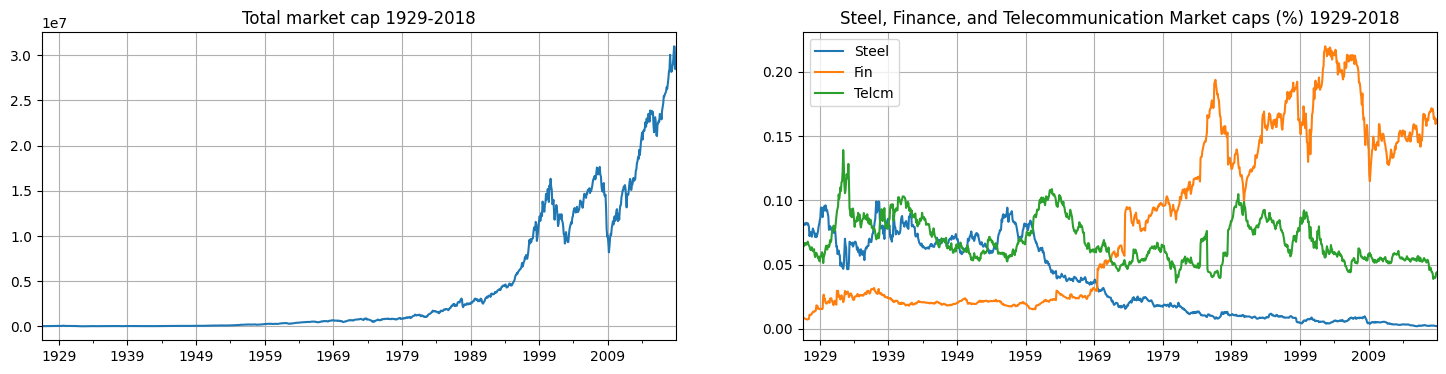

In [6]:
fig, ax = plt.subplots(1,2,figsize=(18,4))
total_mkt_cap.plot(grid=True, ax=ax[0])
ax[0].set_title("Total market cap 1929-2018")

ind_cap_weights[["Steel","Fin","Telcm"]].plot(grid=True, ax=ax[1])
ax[1].set_title("Steel, Finance, and Telecommunication Market caps (%) 1929-2018")
plt.show()

In [7]:
total_market_return = (ind_cap_weights * ind_rets).sum(axis=1)

# suppose to have invested a capital of 1000$ in the market
capital = 1000
total_market_index = capital * (1 + total_market_return).cumprod()

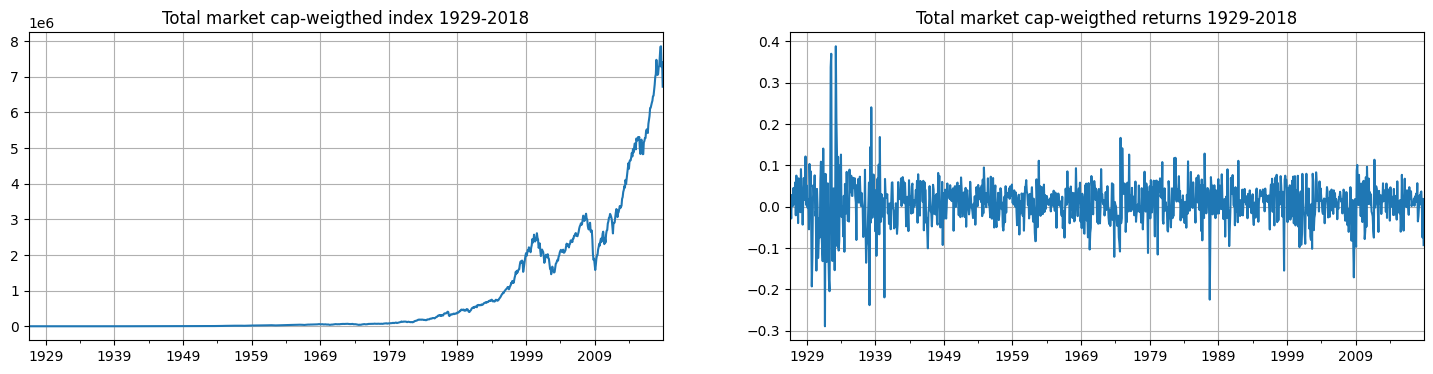

In [8]:
fig, ax = plt.subplots(1,2,figsize=(18,4))

total_market_index.plot(grid=True, ax=ax[0])
ax[0].set_title("Total market cap-weigthed index 1929-2018")

total_market_return.plot(grid=True, ax=ax[1])
ax[1].set_title("Total market cap-weigthed returns 1929-2018")

plt.show()

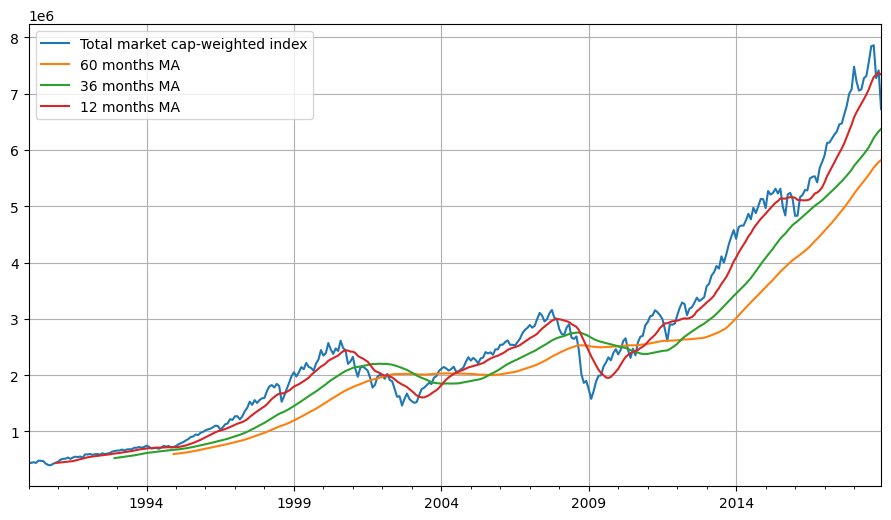

In [9]:
total_market_index["1990":].plot(grid=True, figsize=(11,6), label="Total market cap-weighted index")

total_market_index["1990":].rolling(window=60).mean().plot(grid=True, figsize=(11,6), label="60 months MA") # 5 years MA
total_market_index["1990":].rolling(window=36).mean().plot(grid=True, figsize=(11,6), label="36 months MA") # 3 years MA
total_market_index["1990":].rolling(window=12).mean().plot(grid=True, figsize=(11,6), label="12 months MA") # 1 year MA

plt.legend()
plt.show()

In [10]:
tmi_trail_36_rets = total_market_return.rolling(window=36).aggregate(erk.annualize_rets, periods_per_year=12)

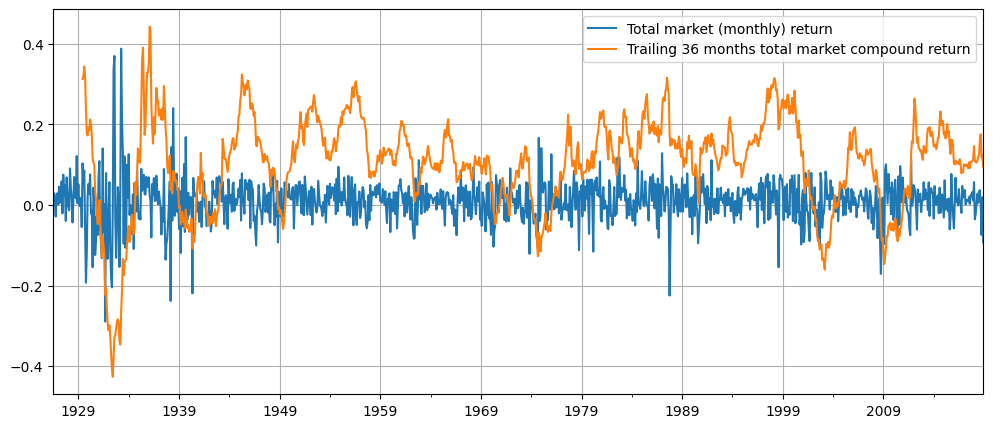

In [11]:
# Plot them
total_market_return.plot(grid=True, figsize=(12,5), label="Total market (monthly) return")
tmi_trail_36_rets.plot(grid=True, figsize=(12,5), label="Trailing 36 months total market compound return")
plt.legend()
plt.show()

In [12]:
rets_trail_36_corr = ind_rets.rolling(window=36).corr()
rets_trail_36_corr.index.names = ["date","industry"]
rets_trail_36_corr.tail()

Food      Beer     Smoke     Games     Books     Hshld  \
date    industry                                                               
2018-12 Whlsl     0.474948  0.356983  0.122672  0.510425  0.803362  0.419280   
        Rtail     0.517856  0.406107  0.030283  0.676464  0.636320  0.358336   
        Meals     0.370187  0.385483  0.122007  0.301516  0.520649  0.308216   
        Fin       0.298823  0.192706  0.027593  0.480276  0.694812  0.162690   
        Other     0.436952  0.376565  0.224010  0.331829  0.558072  0.390610   

                     Clths      Hlth     Chems     Txtls  ...     Telcm  \
date    industry                                          ...             
2018-12 Whlsl     0.570071  0.739764  0.785796  0.634197  ...  0.648092   
        Rtail     0.676598  0.714933  0.626034  0.634202  ...  0.562238   
        Meals     0.302176  0.416193  0.520023  0.491726  ...  0.406184   
        Fin       0.425899  0.658468  0.760151  0.577090  ...  0.420863   
        Other     0.467099  0.645035  0.712511  0.520953  ...  0.607868   

                     Servs     BusEq     Paper     Trans     Whlsl     Rtail  \
date    industry                                                               
2018-12 Whlsl     0.567395  0.543362  0.764252  0.829185  1.000000  0.744842   
        Rtail     0.762616  0.628246  0.656510  0.630615  0.744842  1.000000   
        Meals     0.444629  0.399438  0.627113  0.663358  0.643879  0.616947   
        Fin       0.585418  0.517947  0.670936  0.760730  0.746480  0.611883   
        Other     0.460322  0.434487  0.773798  0.756961  0.767652  0.619918   

                     Meals       Fin     Other  
date    industry                                
2018-12 Whlsl     0.643879  0.746480  0.767652  
        Rtail     0.616947  0.611883  0.619918  
        Meals     1.000000  0.502563  0.605226  
        Fin       0.502563  1.000000  0.734837  
        Other     0.605226  0.734837  1.000000  

[5 rows x 30 columns]

In [13]:
ind_trail_36_corr = rets_trail_36_corr.groupby(level="date").apply(lambda corrmat: corrmat.values.mean())

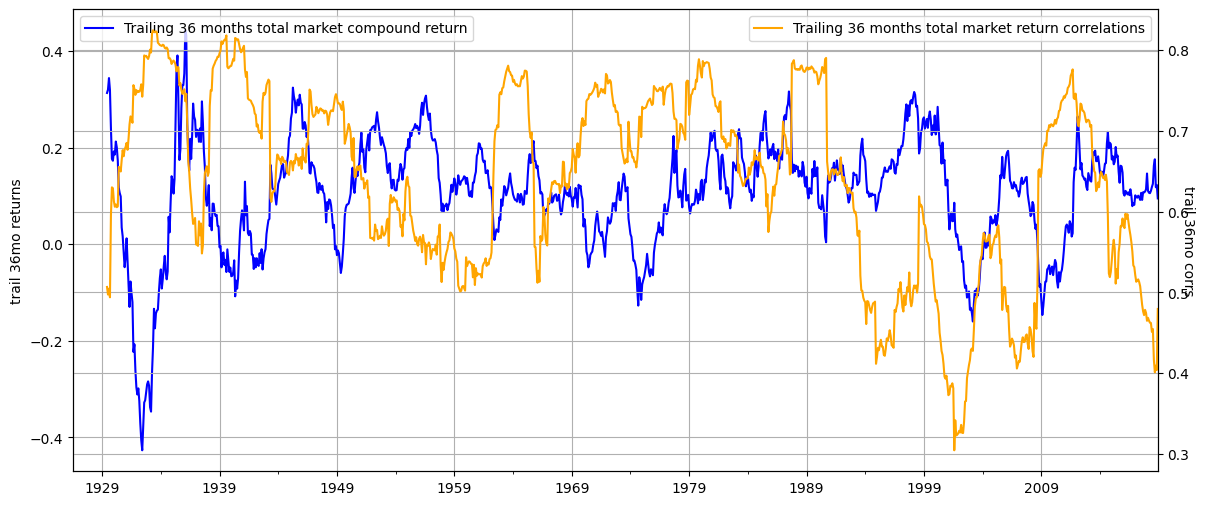

In [14]:
fig, ax1 = plt.subplots(1,1,figsize=(14,6))

tmi_trail_36_rets.plot(ax=ax1, color="blue", grid=True, label="Trailing 36 months total market compound return")
ax2 = ax1.twinx()
ind_trail_36_corr.plot(ax=ax2, color="orange", grid=True, label="Trailing 36 months total market return correlations")

ax1.set_ylabel('trail 36mo returns')
ax2.set_ylabel('trail 36mo corrs',rotation=-90)
ax1.legend(loc=2)
ax2.legend(loc=1)
plt.show()

In [15]:
tmi_trail_36_rets.corr(ind_trail_36_corr)

-0.28010065062884026

## Risk insurance strategies

In [16]:
ind_return = erk.get_ind_file(filetype="rets", nind=nind)
tmi_return = erk.get_total_market_index_returns(nind=nind)

In [19]:
risky_rets = ind_return["2000":][["Steel","Fin","Beer"]]

In [20]:
safe_rets    = pd.DataFrame().reindex_like(risky_rets)
safe_rets[:] = 0.03 / 12

In [24]:
start_value   = 1000
account_value = start_value
floor         = 0.8
floor_value   = floor * account_value

# recall that a drop > 1/m% would break the floor
m = 3

In [25]:
account_history = pd.DataFrame().reindex_like(risky_rets)
cushion_history = pd.DataFrame().reindex_like(risky_rets)
risky_w_history = pd.DataFrame().reindex_like(risky_rets)

In [26]:
risky_wealth = start_value * (1 + risky_rets).cumprod()
risky_wealth.head()

,Steel,Fin,Beer
2000-01,972.300000,955.800000,977.200000
2000-02,1038.805320,874.652580,863.453920
2000-03,1075.059626,1020.632096,864.576410
2000-04,1066.029125,977.255232,896.392822
2000-05,1013.580492,1026.704346,1002.794650


In [27]:
# For loop over dates
for step in range( len(risky_rets.index) ):
    # computing the cushion (as a percentage of the current account value)
    cushion = (account_value - floor_value) / account_value

    # compute the weight for the allocation on the risky asset
    risky_w = m * cushion
    risky_w = np.minimum(risky_w, 1)
    risky_w = np.maximum(risky_w, 0)
    # the last two conditions ensure that the risky weight is in [0,1]

    # compute the weight for the allocation on the safe asset
    safe_w  = 1 - risky_w

    # compute the value allocation
    risky_allocation = risky_w * account_value
    safe_allocation  = safe_w  * account_value

    # compute the new account value: this is given by the new values from both the risky and the safe assets
    account_value = risky_allocation * (1 + risky_rets.iloc[step] ) + safe_allocation  * (1 + safe_rets.iloc[step]  )

    # save data: current account value, cushions, weights
    account_history.iloc[step] = account_value
    cushion_history.iloc[step] = cushion
    risky_w_history.iloc[step] = risky_w

# given the CPPI wealth saved in the account_history, we can get back the CPPI returns
cppi_rets = ( account_history / account_history.shift(1) - 1 ).dropna()

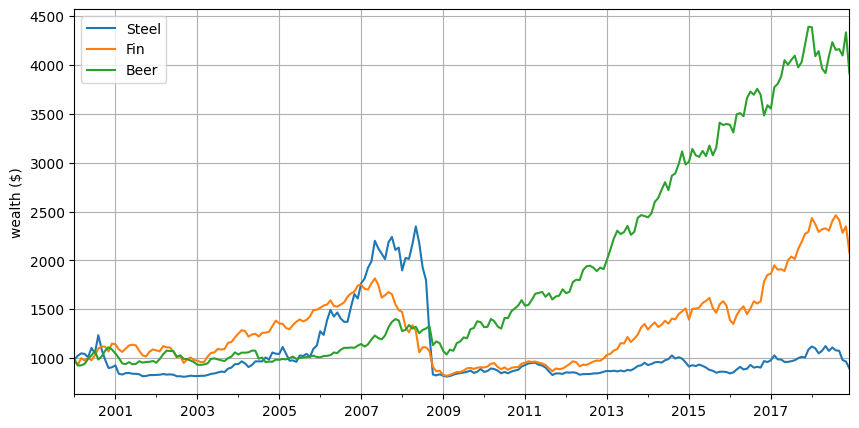

In [28]:
ax = account_history.plot(figsize=(10,5), grid=True)
ax.set_ylabel("wealth ($)")
plt.show()

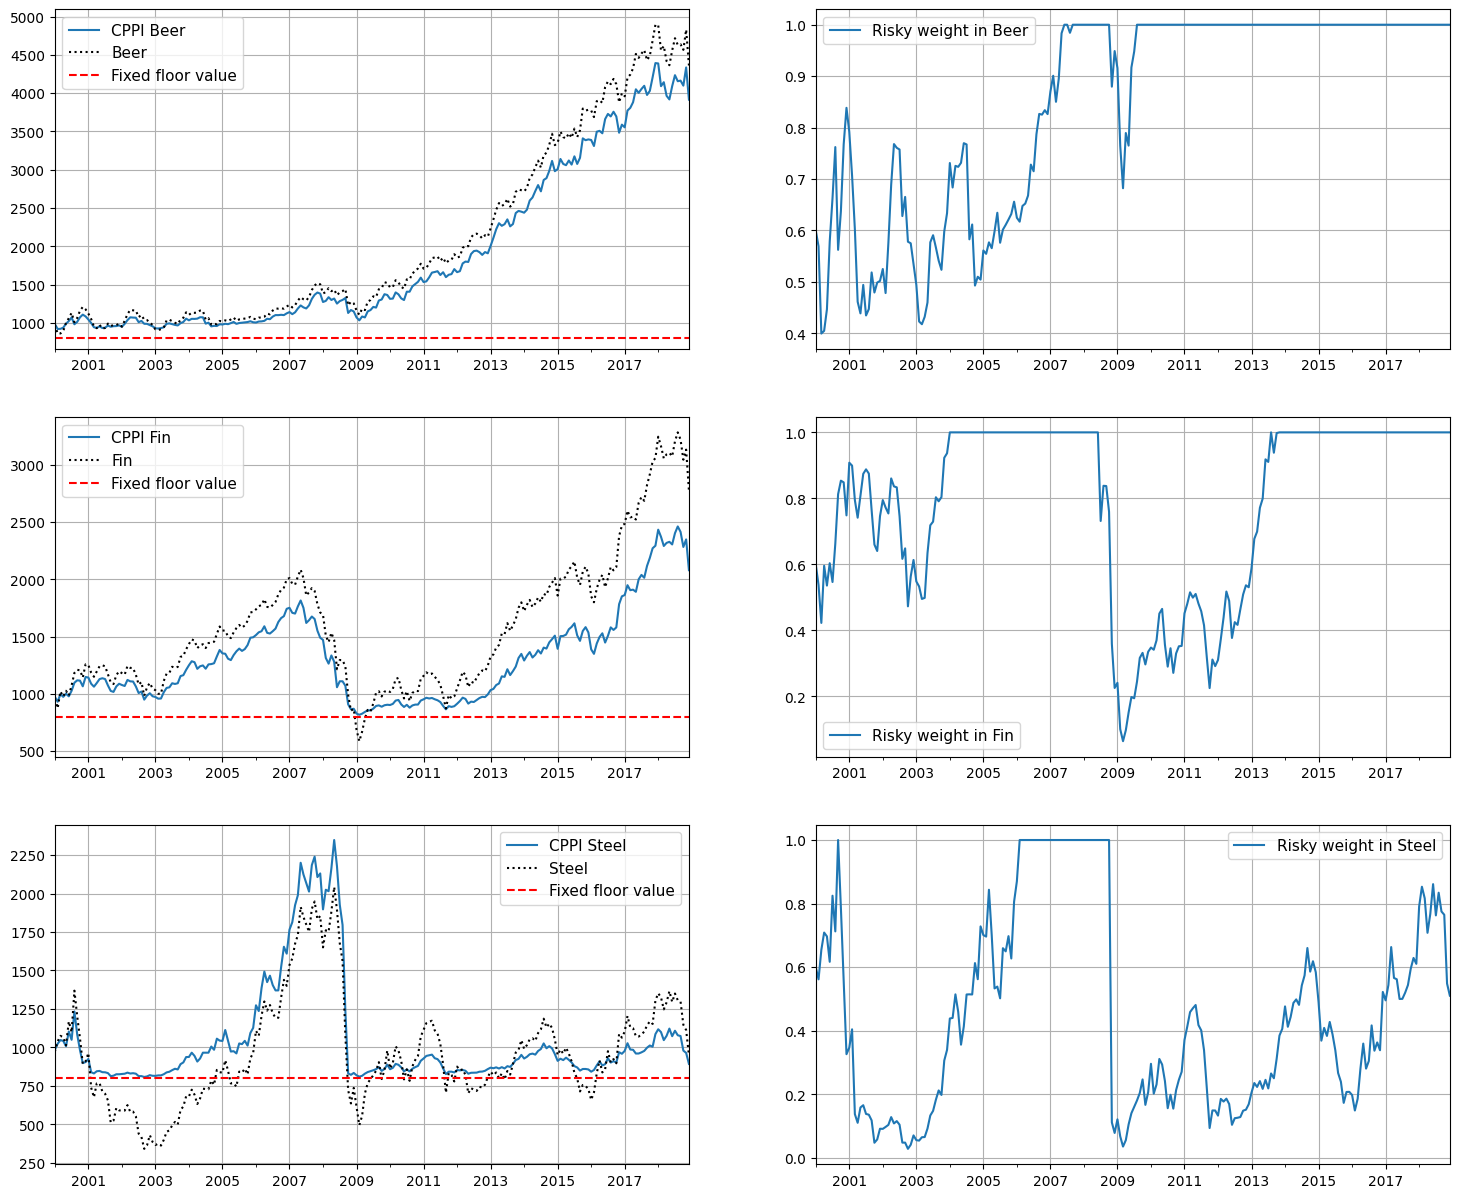

In [29]:
fig, ax = plt.subplots(3,2,figsize=(18,15))
ax = ax.flatten()

# Beer
account_history["Beer"].plot(ax=ax[0], grid=True, label="CPPI Beer")
risky_wealth["Beer"].plot(ax=ax[0], grid=True, label="Beer", style="k:")
ax[0].axhline(y=floor_value, color="r", linestyle="--", label="Fixed floor value")
ax[0].legend(fontsize=11)

# Weights Beer
risky_w_history["Beer"].plot(ax=ax[1], grid=True, label="Risky weight in Beer")
ax[1].legend(fontsize=11)

# Fin
account_history["Fin"].plot(ax=ax[2], grid=True, label="CPPI Fin")
risky_wealth["Fin"].plot(ax=ax[2], grid=True, label="Fin", style="k:")
ax[2].axhline(y=floor_value, color="r", linestyle="--", label="Fixed floor value")
ax[2].legend(fontsize=11)

# Weights Fin
risky_w_history["Fin"].plot(ax=ax[3], grid=True, label="Risky weight in Fin")
ax[3].legend(fontsize=11)

# Steel
account_history["Steel"].plot(ax=ax[4], grid=True, label="CPPI Steel")
risky_wealth["Steel"].plot(ax=ax[4], grid=True, label="Steel", style="k:")
ax[4].axhline(y=floor_value, color="r", linestyle="--", label="Fixed floor value")
ax[4].legend(fontsize=11)

# Weights Steel
risky_w_history["Steel"].plot(ax=ax[5], grid=True, label="Risky weight in Steel")
ax[5].legend(fontsize=11)

plt.show()

In [30]:
erk.summary_stats( risky_rets )

,Ann. return,Ann. vol,Sharpe ratio,Skewness,Kurtosis,Historic CVar,C-F Var,Max Drawdown
Steel,-0.002790,0.312368,-0.102567,-0.326334,4.144381,0.208117,0.150139,-0.758017
Fin,0.055166,0.192909,0.126718,-0.533218,4.995534,0.132175,0.091224,-0.718465
Beer,0.080598,0.138925,0.354314,-0.493545,4.173881,0.091442,0.063015,-0.271368


In [31]:
erk.summary_stats( cppi_rets )

,Ann. return,Ann. vol,Sharpe ratio,Skewness,Kurtosis,Historic CVar,C-F Var,Max Drawdown
Steel,-0.005167,0.174180,-0.196750,-1.995143,17.110190,0.130153,0.091995,-0.655198
Fin,0.040894,0.131678,0.080352,-0.946504,6.051414,0.091621,0.065535,-0.549673
Beer,0.075544,0.115462,0.383772,-0.669250,4.760879,0.074908,0.052923,-0.259582


In [32]:
res = erk.cppi(risky_rets, start_value=1000, floor=0.8, drawdown=0.2, risk_free_rate=0.03, periods_per_year=12)

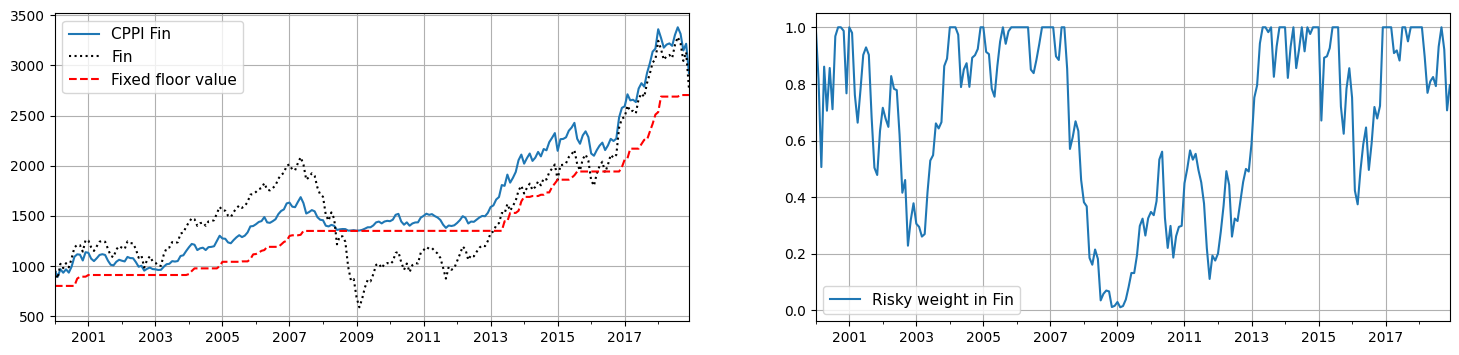

In [33]:
sector = "Fin"

fig, ax = plt.subplots(1,2,figsize=(18,4))
ax = ax.flatten()

res["CPPI wealth"][sector].plot(ax=ax[0], grid=True, label="CPPI "+sector)
res["Risky wealth"][sector].plot(ax=ax[0], grid=True, label=sector, style="k:")
res["Floor value"][sector].plot(ax=ax[0], grid=True, color="r", linestyle="--", label="Fixed floor value")
ax[0].legend(fontsize=11)

# Weights Beer
res["Risky allocation"][sector].plot(ax=ax[1], grid=True, label="Risky weight in "+sector)
ax[1].legend(fontsize=11)

plt.show()

In [34]:
erk.summary_stats( risky_rets[sector] )

,Ann. return,Ann. vol,Sharpe ratio,Skewness,Kurtosis,Historic CVar,C-F Var,Max drawdown
0,0.055166,0.192909,0.126718,-0.533218,4.995534,0.132175,0.091224,-0.718465


In [35]:
erk.summary_stats( res["CPPI returns"][sector] )

,Ann. return,Ann. vol,Sharpe ratio,Skewness,Kurtosis,Historic CVar,C-F Var,Max drawdown
0,0.060906,0.103468,0.290592,-0.162753,3.852636,0.061659,0.04449,-0.198261


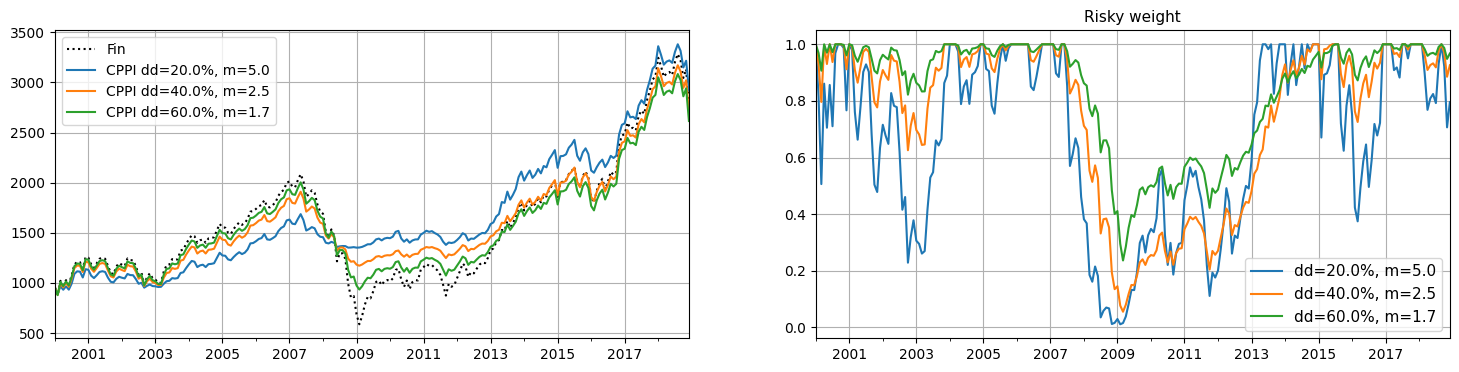

In [36]:
sector = "Fin"
drawdowns = [0.2, 0.4, 0.6]

fig, ax = plt.subplots(1,2,figsize=(18,4))
ax = ax.flatten()

res["Risky wealth"][sector].plot(ax=ax[0], grid=True, style="k:", label=sector)
ax[0].legend()

summ = pd.DataFrame()
for drawdown in drawdowns:
    res = erk.cppi(risky_rets, start_value=1000, floor=0.8, drawdown=drawdown, risk_free_rate=0.03, periods_per_year=12)
    res["CPPI wealth"][sector].plot(ax=ax[0], grid=True, label="CPPI dd={}%, m={}".format(drawdown*100,round(res["m"],1)) )
    res["Risky allocation"][sector].plot(ax=ax[1], grid=True, label="dd={}%, m={}".format(drawdown*100,round(res["m"],1)) )

    summ = pd.concat([summ, erk.summary_stats(res["CPPI returns"][sector])], axis=0)

ax[0].legend()
ax[1].legend(fontsize=11)
ax[1].set_title("Risky weight", fontsize=11)
plt.show()

In [37]:
summ.index = [["DD20%","DD40%","DD60%"]]
summ

,Ann. return,Ann. vol,Sharpe ratio,Skewness,Kurtosis,Historic CVar,C-F Var,Max drawdown
DD20%,0.060906,0.103468,0.290592,-0.162753,3.852636,0.061659,0.044490,-0.198261
DD40%,0.056471,0.122929,0.209429,-0.100930,4.300426,0.076818,0.053106,-0.386458
DD60%,0.054642,0.142893,0.167664,-0.300973,4.190644,0.091483,0.064867,-0.533947


## Random walk generation

In [38]:
prices_1, rets_1 = erk.simulate_gbm_from_returns(n_years=10, n_scenarios=10, mu=0.07, sigma=0.15, periods_per_year=12, start=100.0)
prices_2, rets_2 = erk.simulate_gbm_from_prices(n_years=10, n_scenarios=10, mu=0.07, sigma=0.15, periods_per_year=12, start=100.0)

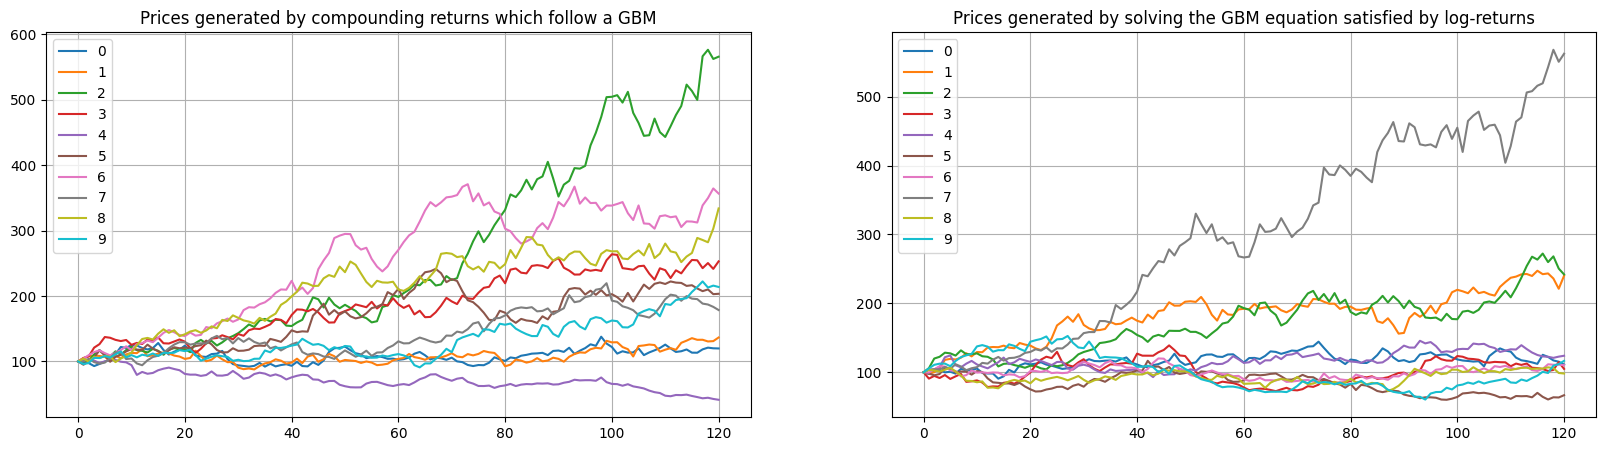

In [39]:
fig, ax = plt.subplots(1, 2, figsize=(20,5))
prices_1.plot(ax=ax[0], grid=True, title="Prices generated by compounding returns which follow a GBM")
prices_2.plot(ax=ax[1], grid=True, title="Prices generated by solving the GBM equation satisfied by log-returns")
plt.show()

In [44]:
from IPython.display import clear_output
import ipywidgets as widgets

In [ ]:
gbm_controls = widgets.interact(erk.show_gbm,
                                n_years = (1, 10, 1),
                                n_scenarios = (1, 100, 1),
                                mu = (-0.30, 0.30, 0.01),
                                sigma = (0.0, 0.50, 0.01),
                                periods_per_year = [12, 52, 252],
                                start = [100]
                               )

In [ ]:
cppi_controls = widgets.interact(erk.show_cppi,
                                 n_years = (1, 10, 1),
                                 n_scenarios = (1, 300, 1),
                                 m = (1, 6, 0.5),
                                 floor = (0.0, 1.0, 0.05),
                                 mu = (-0.2, 0.4, 0.01),
                                 sigma = (0.0, 0.5, 0.01),
                                 risk_free_rate = (0.01, 0.05, 0.01),
                                 periods_per_year = [12, 52, 252],
                                 start = [100],
                                 ymax = widgets.IntSlider(min=0, max=100, value=100, step=1, description="Zoom Y axis")
                                )